In [15]:
import math
import pathlib
import matplotlib.pyplot as plt
import torch
import cv2
import torchsummary
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, Dataset
from torchvision import transforms, utils, datasets, models
from torchvision.datasets.mnist import MNIST
from PIL import Image
from torchvision.io import read_image
from sklearn.model_selection import train_test_split

from poutyne import set_seeds, Model

import numpy as np # linear algebra
import pandas as pd
import os
import json

In [2]:
set_seeds(42)
cuda_device = 0
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

num_classes = 1

batch_size = 8
learning_rate = 0.001
num_epochs = 5

ROOT_DIR = "../petfinder-pawpularity-score"
TRAIN_DIR = "../petfinder-pawpularity-score/train"
TEST_DIR = "../petfinder-pawpularity-score/test"

cuda


In [3]:
def get_train_file_path(id):
    return f"{TRAIN_DIR}/{id}.jpg"
    
df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df['file_path'] = df['Id'].apply(get_train_file_path)

In [4]:
df['Pawpularity'] = df['Pawpularity'] / 100
df['Pawpularity'] = pd.to_numeric(df['Pawpularity'], downcast='float')

In [5]:
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,0.63,../petfinder-pawpularity-score/train/0007de188...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,0.42,../petfinder-pawpularity-score/train/0009c66b9...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,0.28,../petfinder-pawpularity-score/train/0013fd999...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,0.15,../petfinder-pawpularity-score/train/0018df346...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,0.72,../petfinder-pawpularity-score/train/001dc955e...


#### custom dataset

In [6]:
class PawpularityDataset(Dataset):
    def __init__(self, root_dir, df, transform=None):
        self.root_dir = root_dir
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['Pawpularity'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = Image.open(img_path)

        if self.transform is not None:
            img = self.transform(img)

        target = self.targets[index]
        return img, target

In [7]:
train_tranform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

valid_tranform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0)),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [8]:
train, validation = train_test_split(df, test_size=0.2)

In [9]:
train_dataset = PawpularityDataset(ROOT_DIR,train,transform=train_tranform)
valid_dataset = PawpularityDataset(ROOT_DIR,validation,transform=valid_tranform)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=0)

In [11]:
def my_loss(output, target):
    output = torch.flatten(output)
    loss = torch.mean((output - target)**2)
    return loss

def poutyne_train(pytorch_network):
    """
    This function creates a Poutyne Model (see https://poutyne.org/model.html), sends the
    Model on the specified device, and uses the `fit_generator` method to train the
    neural network. At the end, the `evaluate_generator` is used on  the test set.

    Args:
        pytorch_network (torch.nn.Module): The neural network to train.
    """
    #print(pytorch_network)

    optimizer = optim.SGD(pytorch_network.parameters(), lr=learning_rate,momentum=0.9, weight_decay=0.001)
    loss_function = my_loss

    # Poutyne Model on GPU
    model = Model(pytorch_network, optimizer, loss_function, device=device)

    # Train
    history = model.fit_generator(train_loader, valid_loader, epochs=num_epochs)
    
    return model, history

In [12]:
def calculRMSE(model):
    difference_array = []
    label_predictions = []
    image_names = []
    for batch,img_scores in valid_loader:
        # remplir avec des predictions aleatoires (entre 0 et 4)
        predictions = model.predict_on_batch(batch)
        difference_array.extend(((predictions.flatten()*100)-(img_scores.numpy()*100))**2)
        label_predictions.extend(predictions) 
    return np.sqrt(np.mean(difference_array))

In [38]:
resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(512, num_classes, bias = True)
model_resnet18_not_pre, history_resnet18_not_pre = poutyne_train(resnet18)

Epoch: 1/5 Train steps: 992 Val steps: 248 3m32.56s loss: 0.075338 val_loss: 0.047681
Epoch: 2/5 Train steps: 992 Val steps: 248 3m21.83s loss: 0.064649 val_loss: 0.142999
Epoch: 3/5 Train steps: 992 Val steps: 248 3m41.01s loss: 0.064571 val_loss: 0.053851
Epoch: 4/5 Train steps: 992 Val steps: 248 3m25.57s loss: 0.058205 val_loss: 0.092000
Epoch: 5/5 Train steps: 992 Val steps: 248 3m36.97s loss: 0.060515 val_loss: 0.047701


In [36]:
model_resnet18_not_pre.save_weights('model_resnet18_not_pre.pth')
with open('history_resnet18_not_pre.json','w') as jsonFile:
    json.dump(history_resnet18_not_pre, jsonFile)

In [28]:
calculRMSE(model_resnet18_not_pre)

23.953533

In [46]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, num_classes, bias = True)
model_resnet18, history_resnet18 = poutyne_train(resnet18)

Epoch: 1/5 Train steps: 992 Val steps: 248 3m27.58s loss: 0.095797 val_loss: 0.348108
Epoch: 2/5 Train steps: 992 Val steps: 248 3m20.92s loss: 0.082592 val_loss: 0.058352
Epoch: 3/5 Train steps: 992 Val steps: 248 3m35.45s loss: 0.066834 val_loss: 0.058287
Epoch: 4/5 Train steps: 992 Val steps: 248 3m27.50s loss: 0.063448 val_loss: 0.219601
Epoch: 5/5 Train steps: 992 Val steps: 248 3m20.22s loss: 0.065680 val_loss: 0.061497


In [47]:
model_resnet18.save_weights('model_resnet18.pth')
with open('model_resnet18.json','w') as jsonFile:
    json.dump(history_resnet18, jsonFile)

In [48]:
calculRMSE(model_resnet18)

24.80263

In [52]:
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, num_classes, bias = True)
model_vgg16, history_vgg16 = poutyne_train(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\chant/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [01:49<00:00, 5.04MB/s] 


Epoch: 1/5 Train steps: 992 Val steps: 248 8m55.69s loss: 0.049408 val_loss: 0.041411
Epoch: 2/5 Train steps: 992 Val steps: 248 10m55.32s loss: 0.038865 val_loss: 0.043556
Epoch: 3/5 Train steps: 992 Val steps: 248 10m52.13s loss: 0.035998 val_loss: 0.039213
Epoch: 4/5 Train steps: 992 Val steps: 248 10m23.83s loss: 0.034293 val_loss: 0.039378
Epoch: 5/5 Train steps: 992 Val steps: 248 10m14.06s loss: 0.032843 val_loss: 0.037136


In [53]:
model_vgg16.save_weights('model_vgg16.pth')
with open('history_vgg16.json','w') as jsonFile:
    json.dump(history_vgg16, jsonFile)

In [54]:
calculRMSE(model_vgg16)

19.270702

In [25]:
efficientnet_b1 = models.efficientnet_b1(pretrained=True)
num_classes = 1 # on souhaite une sortie lineaire d'une seul class
efficientnet_b1.classifier[1] = nn.Linear(1280, num_classes, bias = True)
model_effb1, history_effb1 = poutyne_train(efficientnet_b1)

Epoch: 1/5 Train steps: 992 Val steps: 248 5m18.43s loss: 0.064082 val_loss: 0.050929
Epoch: 2/5 Train steps: 992 Val steps: 248 5m39.00s loss: 0.050927 val_loss: 0.046004
Epoch: 3/5 Train steps: 992 Val steps: 248 6m14.94s loss: 0.048346 val_loss: 0.045205
Epoch: 4/5 Train steps: 992 Val steps: 248 6m29.23s loss: 0.046003 val_loss: 0.043429
Epoch: 5/5 Train steps: 992 Val steps: 248 6m5.95s loss: 0.045340 val_loss: 0.044949


In [35]:
model_effb1.save_weights('model_effb1.pth')
with open('history_effb1.json','w') as jsonFile:
    json.dump(history_effb1, jsonFile)

In [27]:
calculRMSE(model_effb1)

21.201015

In [55]:
jsonHistory = {
    'history_resnet18_not_pre': history_resnet18_not_pre,
    'history_resnet18': history_resnet18,
    'history_vgg16': history_vgg16,
    'history_effb1': history_effb1
}

with open('./history.json', 'w') as f:
    json.dump(jsonHistory, f, ensure_ascii=False, indent=4)

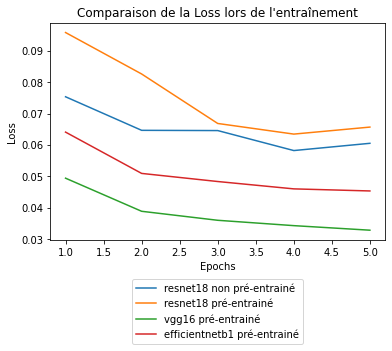

In [56]:
epocs = [i['epoch'] for i in jsonHistory['history_resnet18_not_pre']]

values_history_resnet18_not_pre = [i['loss'] for i in jsonHistory['history_resnet18_not_pre']]
values_history_resnet18 = [i['loss'] for i in jsonHistory['history_resnet18']]
values_history_vgg16 = [i['loss'] for i in jsonHistory['history_vgg16']]
values_history_effb1 = [i['loss'] for i in jsonHistory['history_effb1']]


fig, ax = plt.subplots()  

ax.plot(epocs, values_history_resnet18_not_pre)
ax.plot(epocs, values_history_resnet18)
ax.plot(epocs, values_history_vgg16)
ax.plot(epocs, values_history_effb1)

ax.legend([
    'resnet18 non pré-entrainé',
    'resnet18 pré-entrainé',
    'vgg16 pré-entrainé',
    'efficientnetb1 pré-entrainé'
    ]
                ,loc="lower center",
                bbox_to_anchor=(0.5, -0.5))

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.title('Comparaison de la Loss lors de l\'entraînement')
plt.show()

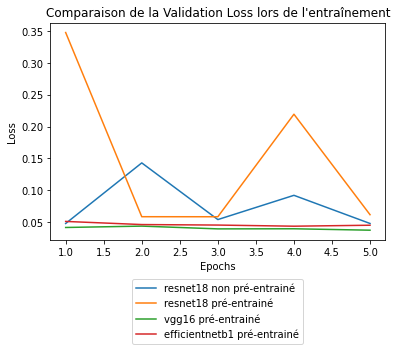

In [57]:
epocs = [i['epoch'] for i in jsonHistory['history_resnet18_not_pre']]

values_history_resnet18_not_pre = [i['val_loss'] for i in jsonHistory['history_resnet18_not_pre']]
values_history_resnet18 = [i['val_loss'] for i in jsonHistory['history_resnet18']]
values_history_vgg16 = [i['val_loss'] for i in jsonHistory['history_vgg16']]
values_history_effb1 = [i['val_loss'] for i in jsonHistory['history_effb1']]

fig, ax = plt.subplots()  

ax.plot(epocs, values_history_resnet18_not_pre)
ax.plot(epocs, values_history_resnet18)
ax.plot(epocs, values_history_vgg16)
ax.plot(epocs, values_history_effb1)

ax.legend([
    'resnet18 non pré-entrainé',
    'resnet18 pré-entrainé',
    'vgg16 pré-entrainé',
    'efficientnetb1 pré-entrainé'
    ]
                ,loc="lower center",
                bbox_to_anchor=(0.5, -0.5))

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.title('Comparaison de la Validation Loss lors de l\'entraînement')
plt.show()